In [168]:
# import package
import numpy as np
from collections import OrderedDict
from collections import defaultdict
from collections import Counter
import matplotlib.pyplot as plt
%matplotlib inline

In [169]:
# Load data
train_lines = open('./data/train.txt','r').readlines()
test_lines = open('./data/test','r').readlines()

# (a) Data preprocessing

In [170]:
# Preprocess data
# Tranfer line from raw txt line to default dict containing 
# id: id number is_spam: 1 represent spam word_count: word count in document
def preprocess(lines):
    output_list = []
    for line in lines:
        doc_dict = {}
        splitted = line.split()
        doc_dict['id'] = splitted[0]
        doc_dict['is_spam'] = splitted[1]=='spam'
        doc_dict['word_count'] = OrderedDict(zip(splitted[2:][::2], np.array(splitted[3:][::2]).astype(int)))
        output_list.append(doc_dict)
    return output_list

In [171]:
# Get training and test documents
train_docs = preprocess(train_lines)
test_docs = preprocess(test_lines)

In [172]:
# Filter to get spam and ham in training sample
train_spam_docs = list(filter(lambda x: x['is_spam'], train_docs))
train_ham_docs = list(filter(lambda x: not x['is_spam'], train_docs))

# (b) What is p(spam) in training data

In [173]:
p_spam_train = len(train_spam_docs)/len(train_docs)
print('Probability of spam: %.4f' % p_spam_train)

Probability of spam: 0.5737


In [174]:
print('Probability of ham: %.4f' % (1-p_spam_train))

Probability of ham: 0.4263


# (c) Determine $p(w_i | spam)$

Get vocabulary counts that in spam and all training documents

In [175]:
# Function to get a vocabulary dict with key=word value=count of word in the given corpus
def get_vocabulary_count(doc_list):
    output_vocabulary_dict = defaultdict(lambda :0)
    for doc_dict in doc_list:
        for word, word_count in doc_dict['word_count'].items():
            output_vocabulary_dict[word]+=word_count
    return output_vocabulary_dict

In [176]:
# Get word count in all trainign documents and spam training documents
train_vocab_count = get_vocabulary_count(train_docs)
train_spam_vocab_count = get_vocabulary_count(train_spam_docs)
train_ham_vocab_count = get_vocabulary_count(train_ham_docs)

Apply m-estimate and get $p(wi|spam)$ or $p(wi|ham)$

In [189]:
# Apply m-estimate and get p(wi|spam) or p(wi|ham)
def get_p_wi_spam(w, train_vocab_count, subset_vocab_count, m_multiplier=1):
    output_dict = defaultdict()
    n = np.sum(list(subset_vocab_count.values()))
    vocab_sum = np.sum(list(train_vocab_count.values()))
    #vocab_sum = len(train_vocab_count)
    p = 1.0/vocab_sum
    m = m_multiplier*vocab_sum
    for w_i in w:
        n_c = subset_vocab_count[w_i]
        output_dict[w_i]=(n_c + m*p)/(n+m)
    return output_dict

In [190]:
words = [key for key in train_vocab_count.keys()]
p_w_given_spam = get_p_wi_spam(words, train_vocab_count, train_spam_vocab_count)
p_w_given_ham = get_p_wi_spam(words, train_vocab_count, train_ham_vocab_count)

In [191]:
print('The top 5 most likely word in spam are:\n\n%s' % 
      '\n'.join([word for word, prob in Counter(p_w_given_spam).most_common(5)]))

The top 5 most likely word in spam are:

enron
a
corp
the
to


In [192]:
print('The top 5 most likely word in ham are:\n\n%s' % 
      '\n'.join([word for word, prob in Counter(p_w_given_ham).most_common(5)]))

The top 5 most likely word in ham are:

aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa
enron
the
to
a


# (d) Classifier and accuracy

A classifier that make predicison by comparing the $log(p(w , spam))$ and  $log(p(w , ham))$

In [193]:
# Code of Naive Bayes Classifier
def classify(test_docs, train_docs, m_multiplier = 1):
    train_spam_docs = list(filter(lambda x: x['is_spam'], train_docs))
    train_ham_docs = list(filter(lambda x: not x['is_spam'], train_docs))
    
    p_spam_train = len(train_spam_docs)/len(train_docs)
    p_ham_train = 1-p_spam_train
    
    train_vocab_count = get_vocabulary_count(train_docs)
    train_spam_vocab_count = get_vocabulary_count(train_spam_docs)
    train_ham_vocab_count = get_vocabulary_count(train_ham_docs)
    
    preds = []
    for doc in test_docs:
        word_count_dict = doc['word_count']
        words = list(word_count_dict.keys())
        
        p_w_given_spam = get_p_wi_spam(words, train_vocab_count, train_spam_vocab_count, m_multiplier=m_multiplier)
        p_w_given_ham = get_p_wi_spam(words, train_vocab_count, train_ham_vocab_count, m_multiplier=m_multiplier)
        
        log_likelihood_spam = np.log(p_spam_train)
        log_likelihood_ham = np.log(p_ham_train)
        for word, word_count in word_count_dict.items():
            log_likelihood_spam += np.log(p_w_given_spam[word])*word_count
            log_likelihood_ham += np.log(p_w_given_ham[word])*word_count

        preds.append(log_likelihood_spam>log_likelihood_ham)
    return preds

In [194]:
# predictions
preds = classify(test_docs, train_docs,1)

In [195]:
# Evaluation of predictions results
def evaluate_predictions(preds, test_docs):
    true_labels = np.array([doc['is_spam'] for doc in test_docs])
    return (preds==true_labels).sum()/len(test_docs)

In [196]:
print('Accuracy: %.3f'% evaluate_predictions(preds, test_docs))

Accuracy: 0.914


In [197]:
accuracy = []
m_multiplier_list = [1,10,100,1000,10000]
for m_multiplier in m_multiplier_list:
    preds = classify(test_docs, train_docs, m_multiplier)
    accuracy.append(evaluate_predictions(preds,test_docs))

# (e) Vary m parameter 

Plot are shown below

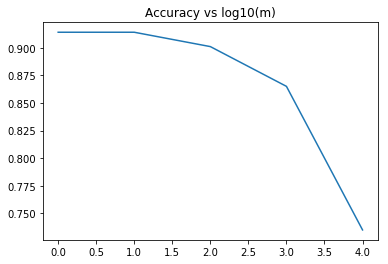

In [198]:
plt.plot(np.log10(m_multiplier_list), accuracy)
plt.title('Accuracy vs log10(m)')

## What does m assume?

$m$ represents the size of the imaginary training data in which word distribution follow practitioner defined priors $p(w_i | spam)$. The larger the $m$ is, the more weight you put in the prior. More 'counts' are assigned to unobserved word relative to observed word.

A small $m$ assume that training samples are very good representations of global samples. 

A large $m$ assume that training samples are less representative and we believe the prior distribution more.

In our case the a large $m$ harms test accuracy.

# (f) What to do if I am a spammer?

If the spam detector is a naive bayes classifer. We should avoid using spam-common words. And we should make our spam email long and make the percentage of common and ham-common words higher. In a word, we should write a spam that contains spam message, while seems like ham in bag of words.